In [1]:
import math
import re
from random import *
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from transformers import PreTrainedTokenizerFast
import json
from tokenizers import Tokenizer

import gc

from transformers import BertTokenizer
import numpy as np
import torch
from transformers import BertTokenizer, BertTokenizerFast
from transformers import PreTrainedTokenizer

**The data is taken from ["https://huggingface.co/api/datasets/stas/openwebtext-10k/parquet/plain_text/train/0.parquet"] 10K slice of OpenWebText - An open-source replication of the WebText dataset from OpenAI.This is a small subset representing the first 10K records from the original dataset - created for testing.The full 8M-record dataset**

In [2]:
df=pd.read_parquet('0.parquet')
df = df.iloc[0:100000]

In [3]:
df.iloc[0]['text']

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

**For each sentence in the file we can do random selection**

In [4]:
#token embedding, segment embedding , masking
#1. tokenization
def remove_numbers(text):
    # Remove English numbers
    text = re.sub(r'\d+', '', text.lower())
    return text
import re

# Function to remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)  # Removes all punctuation except words and spaces

# Function to split text into sentences and remove punctuation from each sentence
def rep_(text):
    # Split the text into sentences using punctuation marks as delimiters
    sentences = re.split(r'(?<=[.!?]) +', text)  # Split based on period, exclamation, and question mark
    
    # Remove punctuation from each sentence and add [SEP] token after each sentence
    cleaned_sentences = [remove_punctuation(sentence) for sentence in sentences]
    
    # Add [CLS] at the beginning and [SEP] between sentences
    return ['[CLS]'] + sum([[s, '[SEP]'] for s in cleaned_sentences], [])[:-1]  # Exclude last [SEP]


df['text']=df['text'].apply(lambda x: remove_numbers(x))
corpus = df['text']
# Apply the function to the dataframe
corpus = corpus.apply(lambda x: rep_(x))
df["processed_text"] = [[sent.split(" ") for sent in sents] for sents in corpus]
corpus = df['processed_text']
#for tokenlist we have to remove puncturations
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
# stop_words = set(stopwords.words('english'))

# def rpuncst(x):
#      # Remove punctuation and stopwords
#     # tokens = [token.lower() for token in tokens]
#     # Apply stemming to each token
#     tokens = [token for token in x if token.lower() not in stop_words]
#     return tokens
# df['text'] = corpus
# corpus=df['text'].apply(lambda x: rpuncst(x))

In [5]:
## Add the ['CLS'] and ['SEP'] and then remove the punctuation 

In [6]:
corpus

0        [[[CLS]], [unfortunately, the, frustration, of...
1        [[[CLS]], [been, going, to, dr], [[SEP]], [gol...
2        [[[CLS]], [i, dont, know, what, dr], [[SEP]], ...
3        [[[CLS]], [im, writing, this, review, to, give...
4        [[[CLS]], [all, the, food, is, great, here], [...
                               ...                        
99995    [[[CLS]], [after, my, final, walk, out, of, qu...
99996    [[[CLS]], [sadly, i, went, to, pick, up, my, y...
99997    [[[CLS]], [been, going, here, since, they, ope...
99998    [[[CLS]], [i, was, really, excited, to, try, o...
99999    [[[CLS]], [i, dont, really, get, why, this, pl...
Name: processed_text, Length: 100000, dtype: object

In [7]:
from collections import Counter

def build_vocab(texts):
    # Initialize counter with special tokens and their fixed indices
    counter = Counter({'[PAD]': 0, '[CLS]':1, '[SEP]':2,'[MASK]': 3})
    
    # Update counter with words from the texts (excluding special tokens)
    for text in texts:
        for sents in text:
            # Exclude [CLS] and [SEP] from the vocabulary (they already have specific indices)
            filtered_text = [word for word in sents if word not in ['[PAD]', '[CLS]', '[SEP]', '[MASK]']]
            if len(filtered_text) > 0:
                counter.update(filtered_text)
    
    # Create the vocabulary, starting from index 4 (as 0-3 are for special tokens)
    vocab = {word: idx for idx, (word, _) in enumerate(counter.items())} 
    
    return vocab

# Create vocabulary
vocab = build_vocab(corpus)

# List of all tokens for the whole text
token_list = []

# Process sentences more efficiently
for sentence in tqdm(df['text'], desc="Processing sentences"):
    token_list.append([vocab[word] for word in sentence.split()])

Processing sentences: 100%|██████████| 100000/100000 [00:02<00:00, 42702.48it/s]


In [8]:
# flattened_list = [item for sublist in token_list for item in sublist]
id2word = {v: k for k, v in vocab.items()}

In [9]:
batch_size = 6
max_mask   = 5  # max masked tokens when 15% exceed, it will only be max_pred
max_len    = max(df['text'].apply(lambda x: len(x.split(" "))))
vocab_size = len(vocab)

In [10]:
vocab_size

187368

In [11]:
max_len

1059

In [12]:
# batch_size = 6
# max_mask   = 5  # max masked tokens when 15% exceed, it will only be max_pred
# max_len    = max([len(i) for i in corpus]) # maximum of length to be padded; 

def make_batch():
    batch = []
    positive = negative = 0  #count of batch size;  we want to have half batch that are positive pairs (i.e., next sentence pairs)
    while positive != batch_size/2 or negative != batch_size/2:
        
        #randomly choose two sentence so we can put [SEP]
        tokens_a_index, tokens_b_index = randrange(len(corpus)), randrange(len(corpus))
        #retrieve the two sentences
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - append CLS and SEP
        input_ids = [vocab['[CLS]']] + tokens_a + [vocab['[SEP]']] + tokens_b + [vocab['[SEP]']]

        #2. segment embedding - [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3. mask language modeling
        #masked 15%, but should be at least 1 but does not exceed max_mask
        n_pred =  min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get the pos that excludes CLS and SEP and shuffle them
        cand_maked_pos = [i for i, token in enumerate(input_ids) if token != vocab['[CLS]'] and token != vocab['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and change the input_ids to [MASK]
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)  #remember the position
            masked_tokens.append(input_ids[pos]) #remember the tokens
            #80% replace with a [MASK], but 10% will replace with a random token
            if random() < 0.1:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = vocab[id2word[index]] # replace
            elif random() < 0.9:  # 80%
                input_ids[pos] = vocab['[MASK]'] # make mask
            else:  #10% do nothing
                pass

        # pad the input_ids and segment ids until the max len
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # pad the masked_tokens and masked_pos to make sure the lenth is max_mask
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #check if first sentence is really comes before the second sentence
        #also make sure positive is exactly half the batch size
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
            
    return batch

In [13]:
batch=make_batch()

In [14]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext.shape

(torch.Size([6, 1059]),
 torch.Size([6, 1059]),
 torch.Size([6, 5]),
 torch.Size([6, 5]),
 torch.Size([6]))

In [15]:
#save the tokenizer for further use
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab, vocab_file)

# from transformers import BertTokenizer, BertTokenizerFast
# BertTokenizer.save_pretrained('/home/jupyter-st125490/toeknizer',vocab)

## BERT

In [16]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, _model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [17]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [18]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# print(device, torch.cuda.get_device_name(0))
print(get_attn_pad_mask(input_ids, input_ids, device).shape)

torch.Size([6, 1059, 1059])


In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [20]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

In [21]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2


In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

In [23]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device, dropout_prob=0.1):
        super(BERT, self).__init__()
        
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        
        # Embedding layer
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Transformer layers
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        
        # Linear layers for classification and MLM
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        
        # Decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        
        # Device for model
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        # Ensure that inputs are on the same device
        device = input_ids.device
        
        # Embedding layer
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        masked_pos = masked_pos.to(device)
        
        output = self.embedding(input_ids, segment_ids).to(device)
        
        # Apply dropout after the embedding layer
        output = self.dropout(output)
        
        # Attention mask for padding
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device).to(device)
        
        # Pass through transformer layers with dropout
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
            output = self.dropout(output)  # Dropout after each transformer layer
        
        # Next Sentence Prediction (NSP)
        logits_nsp = self._predict_nsp(output)
        
        # Masked Language Modeling (MLM)
        logits_lm = self._predict_mlm(output, masked_pos)
        
        # Return both logits for MLM and NSP
        return logits_lm, logits_nsp

    def _predict_nsp(self, output):
        h_pooled = self.activ(self.fc(output[:, 0]))  # Use first token for NSP
        return self.classifier(h_pooled)

    def _predict_mlm(self, output, masked_pos):
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))
        h_masked = torch.gather(output, 1, masked_pos)
        h_masked = self.norm(F.gelu(self.linear(h_masked)))
        
        # Apply dropout before the final decoding
        h_masked = self.dropout(h_masked)
        
        return self.decoder(h_masked) + self.decoder_bias
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        
        # Apply dropout after the embedding layer        
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        
        return output


In [25]:
from tqdm.auto import tqdm

n_layers = 12  # number of Encoder of Encoder Layer
n_heads  = 12  # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = d_model * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2
dropout = 0.3
num_epoch = 100
model = BERT(
    n_layers, 
    n_heads, 
    d_model, 
    d_ff, 
    d_k, 
    n_segments, 
    vocab_size, 
    max_len, 
    device, 
    dropout_prob=dropout
).to(device)  # Move model to GPU

In [26]:
gc.collect()

0

In [27]:
# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the batch of inputs
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

# Move inputs to GPU
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

# Training loop with tqdm
for epoch in tqdm(range(num_epoch), desc="Training Epochs"):
    optimizer.zero_grad()
    # Forward pass through the model
    input_ids = input_ids.to(device)
    segment_ids = segment_ids.to(device)
    masked_tokens = masked_tokens.to(device)
    masked_pos = masked_pos.to(device)
    isNext = isNext.to(device)
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)  # Automatically split across GPUs if necessary
    
    # Masked Language Modeling loss
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens)  # (bs, vocab_size, max_mask) vs (bs, max_mask)
    loss_lm = loss_lm.float().mean()  # Mean across batch

    # Next Sentence Prediction loss
    loss_nsp = criterion(logits_nsp, isNext)  # (bs, 2) vs (bs,)

    # Combine the two losses
    loss = loss_lm + loss_nsp
    gc.collect()
    
    # Print the loss every 100 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d} loss = {loss.item():.6f}')

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 00 loss = 147.428314
Epoch: 10 loss = 49.319546
Epoch: 20 loss = 39.760391
Epoch: 30 loss = 40.245693
Epoch: 40 loss = 38.221573
Epoch: 50 loss = 37.665619
Epoch: 60 loss = 34.779301
Epoch: 70 loss = 29.251232
Epoch: 80 loss = 34.512959
Epoch: 90 loss = 35.128799


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.parallel import DataParallel
import gc
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sample Model for demonstration (replace with your own model)

# Custom Dataset for loading your data
class MyDataset(Dataset):
    def __init__(self, input_ids, segment_ids, masked_tokens, masked_pos, isNext):
        self.input_ids = input_ids
        self.segment_ids = segment_ids
        self.masked_tokens = masked_tokens
        self.masked_pos = masked_pos
        self.isNext = isNext
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.segment_ids[idx], 
                self.masked_tokens[idx], self.masked_pos[idx], self.isNext[idx])
train_loss = []
valid_loss = []
# Training and Validation Loop
def train(model, input_ids, segment_ids, masked_tokens, masked_pos, isNext, num_epochs=100, batch_size=6, val_split=0.2):

    # Create dataset and split it into train and validation sets
    dataset = MyDataset(input_ids, segment_ids, masked_tokens, masked_pos, isNext)
    
    # Split the dataset into training and validation sets
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1 )  # Adjust T_max accordingly


    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        optimizer.zero_grad()

        gc.collect()
        torch.cuda.empty_cache()

        for batch in train_loader:
            input_ids_batch, segment_ids_batch, masked_tokens_batch, masked_pos_batch, isNext_batch = batch

            # Move data to the correct device (cuda:0)
            input_ids_batch = input_ids_batch.to(device)
            segment_ids_batch = segment_ids_batch.to(device)
            masked_tokens_batch = masked_tokens_batch.to(device)
            masked_pos_batch = masked_pos_batch.to(device)
            isNext_batch = isNext_batch.to(device)

            # Forward pass using DataParallel (which will distribute across GPUs)
            logits_lm, logits_nsp = model(input_ids_batch, segment_ids_batch, masked_pos_batch)

            # Compute the loss for the MLM and NSP tasks
            loss_lm = criterion(logits_lm.view(-1, logits_lm.size(-1)), masked_tokens_batch.view(-1))
            loss_nsp = criterion(logits_nsp, isNext_batch)

            # Combine the losses
            loss = loss_lm + loss_nsp

            # Backward pass and optimization step
            loss.backward()
            gc.collect()
            optimizer.step()
        if epoch % 10 == 0:
            train_loss.append(loss)
            print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Validation phase (after every epoch)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                val_input_ids_batch, val_segment_ids_batch, val_masked_tokens_batch, val_masked_pos_batch, val_isNext_batch = batch

                # Move data to the correct device (cuda:0)
                val_input_ids_batch = val_input_ids_batch.to(device)
                val_segment_ids_batch = val_segment_ids_batch.to(device)
                val_masked_tokens_batch = val_masked_tokens_batch.to(device)
                val_masked_pos_batch = val_masked_pos_batch.to(device)
                val_isNext_batch = val_isNext_batch.to(device)

                # Forward pass for validation
                val_logits_lm, val_logits_nsp = model(val_input_ids_batch, val_segment_ids_batch, val_masked_pos_batch)

                # Compute the validation loss
                val_loss_lm = criterion(val_logits_lm.view(-1, val_logits_lm.size(-1)), val_masked_tokens_batch.view(-1))
                val_loss_nsp = criterion(val_logits_nsp, val_isNext_batch)

                # Combine the validation losses
                val_loss += val_loss_lm + val_loss_nsp
                scheduler.step(val_loss)
                gc.collect()
        # val_loss /= len(val_loader)  # Average validation loss
            if epoch % 10 == 0:
                valid_loss.append(val_loss)
                print(f'Validation Loss after Epoch {epoch}: {val_loss.item()}')

# Run the training on 3 GPUs using DataParallel
train(model, input_ids, segment_ids, masked_tokens, masked_pos, isNext)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 154.89695739746094
Validation Loss after Epoch 0: 144.46517944335938
Epoch 10, Loss: 52.394065856933594
Validation Loss after Epoch 10: 90.4301986694336
Epoch 20, Loss: 36.581871032714844
Validation Loss after Epoch 20: 89.24308013916016
Epoch 30, Loss: 30.157041549682617
Validation Loss after Epoch 30: 90.12097930908203
Epoch 40, Loss: 33.172752380371094
Validation Loss after Epoch 40: 85.59182739257812
Epoch 50, Loss: 30.41604995727539
Validation Loss after Epoch 50: 87.55838775634766
Epoch 60, Loss: 30.886587142944336
Validation Loss after Epoch 60: 92.342529296875
Epoch 70, Loss: 30.633466720581055
Validation Loss after Epoch 70: 89.0675048828125
Epoch 80, Loss: 37.52654266357422
Validation Loss after Epoch 80: 88.00129699707031
Epoch 90, Loss: 31.93903923034668
Validation Loss after Epoch 90: 89.87641906738281


**BERT MODEL over optimize so quickly potential changes we made**
* number of layer to 8
* added dropout to 0.3
* added ReduceLROnPlateau
* added weighted decay (L2)
* This is the best we can get the above one is number of layers 8
* The sample is non random of  fisrt 100000 samples the training took almost an 30-45 mins
* If enough time is left we will try to do other experiements to optimize the pretrain model
* with this lets move to siamese network

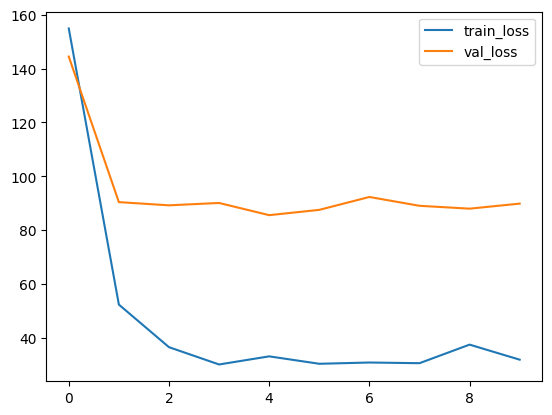

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')

plt.legend()


In [25]:
##
torch.save(model, 'BERT2')

## siamese network

In [15]:
# device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device = "cpu"
print(device, torch.cuda.get_device_name(0))

cpu NVIDIA GeForce RTX 2080 Ti


In [23]:
from datasets import load_dataset

# Load MNLI dataset from Hugging Face
dataset = load_dataset("multi_nli")

# Select a subset of the dataset (e.g., first 1000 samples of the training set)
dataset = dataset.shuffle()
train_data = dataset['train'].select(range(100))  # Change 1000 to your desired subset size
validation_data = dataset['validation_matched'].select(range(20))

Using custom data configuration default
Reusing dataset multi_nli (/home/jupyter-st125490/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/jupyter-st125490/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-708c61078cdba523.arrow
Loading cached shuffled indices for dataset at /home/jupyter-st125490/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-0298da4c8dfd61f7.arrow


In [17]:

# Assuming you've already defined your BERT architecture like this
n_layers = 12  # number of Encoder of Encoder Layer
n_heads  = 12   # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = d_model * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2
vocab_size = 187368
max_len = 1059
# Initialize your custom BERT model
bert_ = BERT(
    n_layers, 
    n_heads, 
    d_model, 
    d_ff, 
    d_k, 
    n_segments, 
    vocab_size, 
    max_len, 
    device
).to(device)  # Move model to GPU if available

# Load the pretrained model weights (ensure 'BERT' is the correct path)
pretrained_model = torch.load('BERT2', weights_only=False)  # Make sure the path is correct
pretrained_model_state_dict = pretrained_model.state_dict()

# Get the model's state dict
model_state_dict = bert_.state_dict()

# Iterate through the pretrained model's state dict and load weights
for name, param in pretrained_model_state_dict.items():
    if name in model_state_dict:
        model_state_dict[name].copy_(param)  # Copy weights if the name matches

# Now load the updated state dict into your model
bert_.load_state_dict(model_state_dict)

# # Optionally, you can test if everything loaded correctly
# model.eval()  # Set to evaluation mode
# print("Model loaded successfully!")


<All keys matched successfully>

In [18]:
bert_

BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(187368, 768)
    (pos_embed): Embedding(1059, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=True)
        (W_K): Linear(in_features=768, out_features=768, bias=True)
        (W_V): Linear(in_features=768, out_features=768, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_fe

In [19]:
class SiameseNetworkWithBERT(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased', num_labels=3):
        super(SiameseNetworkWithBERT, self).__init__()
        # Load the pre-trained BERT model
        self.bert = bert_
        for param in self.bert.parameters():
                param.requires_grad = True  #
        # Classifier to map concatenated embeddings to final output
        self.classifier = nn.Linear(d_model * 3, num_labels)  # [u, v, |u - v|]

    def mean_pooling(self, token_embeddings, attention_mask):
        # We create the attention mask to ignore the padding tokens while calculating the mean
        token_embeddings = token_embeddings.cpu().detach().numpy()
        token_embeddings = token_embeddings * attention_mask[:,:,np.newaxis]
        # Sum the embeddings along the sequence length axis (dim=1) and divide by the number of tokens
        pooled_output = token_embeddings.sum(axis=1) / np.sum(attention_mask, axis=1, keepdims=True)
        return pooled_output

    def forward_one(self, input_ids, attention_mask):
        # Get batch size and sequence length
        batch_size, max_len = input_ids.shape
        
        # Create segment_ids (assuming all inputs belong to the same segment)
        segment_ids = torch.zeros(batch_size, max_len, dtype=torch.int32).to(device) 
        
        # Get the output embeddings from the pre-trained BERT model
        output = self.bert.get_last_hidden_state(torch.tensor(input_ids).to(device), segment_ids)
        # Apply mean pooling to the token embeddings
        pooled_embedding = self.mean_pooling(output, attention_mask)
        return pooled_embedding

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Forward pass through the pre-trained BERT for both sentences
        embedding1 = self.forward_one(input_ids=input_ids1, attention_mask=attention_mask1)
        embedding2 = self.forward_one(input_ids=input_ids2, attention_mask=attention_mask2)
        # print(embedding1)
        # print(embedding2)
        # Compute the absolute difference between embeddings
        abs_diff = np.abs(embedding1 - embedding2)
        
        # Concatenate embeddings: [u, v, |u - v|]
        combined_embedding = np.concatenate((embedding1, embedding2, abs_diff), axis=1)
        # print(combined_embedding.shape)
        # Forward pass through the classifier to get logits
        logits = self.classifier(torch.tensor(combined_embedding).float())
        return logits

In [24]:

# Load the custom tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizer.pad_token = '[PAD]'
# tokenizer.cls_token = '[CLS]'
# tokenizer.sep_token = '[SEP]'
# tokenizer.mask_token = '[MASK]'
# Max length
# Preprocessing function for the entire batch
def preprocess_function(batch):
    # # Tokenize both premise and hypothesis for the entire batch
    encoding1 = tokenizer.batch_encode_plus(batch['premise'], padding='max_length', truncation=True, max_length=max_len, return_tensors = "pt",add_special_tokens=False)
    encoding2 = tokenizer.batch_encode_plus(batch['hypothesis'], padding='max_length', truncation=True, max_length=max_len, return_tensors ="pt",add_special_tokens=False)
    # Apply masking to input_ids (assuming mask_tokens replaces input_ids in-place)
    #can take random input
     # Similarly for second sentence
    
    # Collect the labels
    labels = torch.tensor(batch['label'])
    # Convert any tensors into numpy arrays

    # Return the preprocessed data
    return {
        'input_ids1': encoding1['input_ids'].cpu().detach().numpy(),
        'attention_mask1': encoding1['attention_mask'].cpu().detach().numpy(),
        'input_ids2': encoding2['input_ids'].cpu().detach().numpy(),
        'attention_mask2': encoding2['attention_mask'].cpu().detach().numpy(),
        'labels': labels.cpu().detach().numpy()
    }

tokenized_datatset=train_data.map(preprocess_function, batched=True)


Parameter 'function'=<function preprocess_function at 0x75c4fadd32e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

In [42]:
from transformers import BertTokenizer
import numpy as np
import torch
from transformers import BertTokenizer, BertTokenizerFast
from transformers import PreTrainedTokenizer
from torch.utils.data import DataLoader

# Load the custom tokenizer
max_len = 1059
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from torch.utils.data import Dataset
from transformers import BertTokenizer

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sentence pair for this index
        premise = self.data[idx]['premise']
        hypothesis = self.data[idx]['hypothesis']
        label = self.data[idx]['label']
        
        # Tokenize the input sentences using BERT tokenizer
        encoding1 = self.tokenizer(premise, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt', add_special_tokens=True)
        encoding2 = self.tokenizer(hypothesis, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt', add_special_tokens=True)
        
        # Return the tokenized data as a dictionary, without the batch dimension
        return {
            'input_ids1': encoding1['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask1': encoding1['attention_mask'].squeeze(0),
            'input_ids2': encoding2['input_ids'].squeeze(0),
            'attention_mask2': encoding2['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)}

# Example usage:
dataset = CustomDataset(train_data, tokenizer, max_len)
# Create DataLoader
train_dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# for batch in train_dataloader:
#     batch['input_ids1'] = batch['input_ids1'].to(device)
#     batch['attention_mask1'] = batch['attention_mask1'].to(device)
#     batch['input_ids2'] = batch['input_ids2'].to(device)
#     batch['attention_mask2'] = batch['attention_mask2'].to(device)
#     batch['labels'] = batch['labels'].to(device)

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datatset, batch_size=6, shuffle=True)

In [20]:
# Initialize the model and optimizer
model = SiameseNetworkWithBERT(num_labels=3, pretrained_model_name='BERT2')  # 3 classes: entailment, contradiction, neutral
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    
    for batch in train_dataloader:
        processed_batch = preprocess_function(batch)
        # Get inputs from the batch
        input_ids1 = processed_batch['input_ids1']
        attention_mask1 = processed_batch['attention_mask1']
        input_ids2 = processed_batch['input_ids2']
        attention_mask2 = processed_batch['attention_mask2']
        labels = processed_batch['labels']
        # Move inputs and labels to GPU if available
        if torch.cuda.is_available():
            input_ids1 = input_ids1
            attention_mask1 = attention_mask1
            input_ids2 = input_ids2
            attention_mask2 = attention_mask2
            labels = labels

        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        # print(loss)
        # Compute the loss
        # print(logits, labels)
        labels = torch.tensor(labels)
        loss = loss_fn(logits, labels)
        # Backward pass and optimization
        loss.backward()
        # torch.cuda.empty_cache()
        gc.collect()
        optimizer.step()

        total_loss += loss.item()
    # print(f'Epoch: {epoch:02d} loss = {total_loss:.6f}')

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")


/tmp/ipykernel_2585079/3673845368.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label'])
 10%|█         | 1/10 [05:09<46:27, 309.72s/it]

Epoch 1, Loss: 3.4602013265385345


 20%|██        | 2/10 [10:20<41:24, 310.61s/it]

Epoch 2, Loss: 2.3845054822809555


 30%|███       | 3/10 [15:07<34:57, 299.62s/it]

Epoch 3, Loss: 2.2453983741648056


 40%|████      | 4/10 [19:35<28:43, 287.28s/it]

Epoch 4, Loss: 2.5755619897561917


 50%|█████     | 5/10 [24:12<23:37, 283.60s/it]

Epoch 5, Loss: 1.7367924697258894


 60%|██████    | 6/10 [28:35<18:25, 276.35s/it]

Epoch 6, Loss: 1.5442155213917004


 70%|███████   | 7/10 [33:32<14:09, 283.14s/it]

Epoch 7, Loss: 3.303265052683213


 80%|████████  | 8/10 [38:08<09:21, 280.93s/it]

Epoch 8, Loss: 2.8062566308414234


 90%|█████████ | 9/10 [42:52<04:41, 281.75s/it]

Epoch 9, Loss: 1.470043873085695


100%|██████████| 10/10 [47:17<00:00, 283.74s/it]

Epoch 10, Loss: 2.1432681364171646


In [21]:
# model = SiameseNetworkWithBERT(num_labels=3, pretrained_model_name='BERT')  # 3 classes: entailment, contradiction, neutral
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = nn.CrossEntropyLoss()

# accumulation_steps = 4  # Number of mini-batches to accumulate gradients over

# # Training loop
# num_epochs = 10
# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     total_loss = 0
#     optimizer.zero_grad()  # Reset gradients at the beginning of each epoch
    
#     for step, batch in enumerate(train_dataloader):
#         input_ids1 = batch['input_ids1'].to(device)
#         attention_mask1 = batch['attention_mask1'].to(device)
#         input_ids2 = batch['input_ids2'].to(device)
#         attention_mask2 = batch['attention_mask2'].to(device)
#         labels = batch['labels'].to(device)

#         # Forward pass
#         logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
#         loss = loss_fn(logits, labels)

#         # Backward pass (accumulate gradients)
#         loss.backward()

#         # Update model after every 'accumulation_steps' steps
#         if (step + 1) % accumulation_steps == 0:
#             optimizer.step()
#             optimizer.zero_grad()  # Reset gradients
#             gc.collect()  # Clear memory after each optimizer step

#         total_loss += loss.item()

#     print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")


In [33]:
torch.save(model,'Saimes')

## Inference

In [24]:
def inference(model, tokenizer, sentence1, sentence2, device):
    # Tokenize the input sentences
    inputs = tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
    
    # Move the tensors to the same device as the model (CPU or GPU)
    input_ids1 = inputs['input_ids'].detach().numpy()
    attention_mask1 = inputs['attention_mask'].detach().numpy()
    input_ids2 = inputs['input_ids'].detach().numpy()
    attention_mask2 = inputs['attention_mask'].detach().numpy()
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradients for inference
    with torch.no_grad():
        # Forward pass through the model
        logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
    
    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    
    # Get the predicted class (the index with the highest probability)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    return predicted_class, probabilities

# Example Usage:
device="cpu"
# Load the pretrained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()  # Set model to evaluation mode

# Example sentences for inference
sentence1 = "she smiles bad"
sentence2 ="she was so happy she couldn't stop smiling"

# Perform inference
predicted_class, probabilities = inference(model, tokenizer, sentence1, sentence2, "cpu")

# Print results
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")


Predicted class: 1
Probabilities: tensor([[0.3692, 0.5062, 0.1246]])


**The above prediction makes sense even though the model has been fluctuating lets try one implication**

In [29]:
# Example Usage:
device="cpu"
# Load the pretrained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()  # Set model to evaluation mode

# Example sentences for inference
sentence1 = "I took Car"
sentence2 ="It is raning outside"

# Perform inference
predicted_class, probabilities = inference(model, tokenizer, sentence1, sentence2, "cpu")

# Print results
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

Predicted class: 0
Probabilities: tensor([[0.5201, 0.4033, 0.0766]])


**Even though the model get confused but it make sense i took car because it is raining outside let us take one more example with neutral**

In [30]:
# Example Usage:
device="cpu"
# Load the pretrained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()  # Set model to evaluation mode

# Example sentences for inference
sentence1 = "The sun is shining brightly."
sentence2 ="He enjoys watching movies."

# Perform inference
predicted_class, probabilities = inference(model, tokenizer, sentence1, sentence2, "cpu")

# Print results
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

Predicted class: 1
Probabilities: tensor([[0.3742, 0.4762, 0.1496]])


**even though the sentences are neutral but it is also becoming a cause it had to tell the distinction early between entitlement and neurtral statement may be because my subsamples are not enough to exmplain them**

In [21]:
# Load the pretrained model weights (ensure 'BERT' is the correct path)
pretrained_model = torch.load('Saimes', weights_only=False)  # Make sure the path is correct
pretrained_model_state_dict = pretrained_model.state_dict()
model = SiameseNetworkWithBERT(num_labels=3, pretrained_model_name='BERT2')  # 3 classes: entailment, contradiction, neutral

# Get the model's state dict
model_state_dict = model.state_dict()

# Iterate through the pretrained model's state dict and load weights
for name, param in pretrained_model_state_dict.items():
    if name in model_state_dict:
        model_state_dict[name].copy_(param)  # Copy weights if the name matches

# Now load the updated state dict into your model
model.load_state_dict(model_state_dict)

# # Optionally, you can test if everything loaded correctly
# model.eval()  # Set to evaluation mode
# print("Model loaded successfully!")


<All keys matched successfully>

In [22]:
model

SiameseNetworkWithBERT(
  (bert): BERT(
    (embedding): Embedding(
      (tok_embed): Embedding(187368, 768)
      (pos_embed): Embedding(1059, 768)
      (seg_embed): Embedding(2, 768)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x EncoderLayer(
        (enc_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=768, out_features=768, bias=True)
          (W_K): Linear(in_features=768, out_features=768, bias=True)
          (W_V): Linear(in_features=768, out_features=768, bias=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (activ): Tanh()
    (linear): Linear(in_features=768, out_features=768, bias=True)
    (norm): 

In [66]:
def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

model.eval()
# classifier_head.eval()
total_similarity = 0
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        processed_batch = preprocess_function(batch)
        # Get inputs from the batch
        input_ids1 = processed_batch['input_ids1']
        attention_mask1 = processed_batch['attention_mask1']
        input_ids2 = processed_batch['input_ids2']
        attention_mask2 = processed_batch['attention_mask2']
        labels = processed_batch['labels']
        
        embedding1 = model.forward_one(input_ids=input_ids1, attention_mask=attention_mask1).reshape(-1)
        embedding2 = model.forward_one(input_ids=input_ids2, attention_mask=attention_mask2).reshape(-1)
        
        similarity_score = cosine_similarity(embedding1, embedding2.T)
        total_similarity += similarity_score
        # print(average_similarity/len(train_dataloader))
average_similarity = total_similarity / len(train_dataloader)
print(f"Average Cosine Similarity: {average_similarity:.4f}")

/tmp/ipykernel_2656451/3384133285.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label'])
100%|██████████| 17/17 [04:16<00:00, 15.08s/it]

Average Cosine Similarity: 0.9977


## Current Observation and challages

In [68]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Model','Accuracy_MNLI', 'Traning Loss MNLI', 'Traning Time'])
v['Model'] = ['Bert Pretrain siamese']
v['Accuracy_MNLI'] = ['0.9977']
v['Traning Loss MNLI'] = ['2.71']
v['Traning Time'] = ['<40 min']
v['sample size'] = ['> 1000']
display(v)

,Model,Accuracy_MNLI,Traning Loss MNLI,Traning Time,sample size
0,Bert Pretrain siamese,0.9977,2.71,<40 min,> 1000


**Although the currecnt model show 0.977 accuracy but the model might not perform better i.e we can not just rely on cosine-similarity since the fine-tuning is done on small dataset**
**Current Challanges facedwith the reuqirued memory since the memory was limited we use gc but require convert into numpy type which cause performance to go down**

We tried to perform crossvalidation with the above model and observed that bert model over optimized very quickly , we tried couple approaches ,
we used dynamic learning rate, drop out 0.3 has given better performance in pretrained siames network

* Further changes to the model , proposal could be model distillation since the model is trying to over opimize and computational limitation is really a challange with bert model
* similar task can be done by simple attention mechanism with small dataset, here BERT model is only requires with large language text data which is not possible 
with the required resources.
* general peformance metric like accuracy can cause baised. In general we can also:
* Perplexity: In language modeling and text generation tasks, perplexity can be more informative.It's less sensitive to n-gram matching than BLEU.
* ROUGE: Particularly useful in summarization tasks, ROUGE measures the overlap of n-grams, word sequences, and word pairs between the model output and reference output.
* Human Evaluation: Sometimes, human evaluation can provide a much better understanding of model performance, especially in tasks like translation or text generation. Humans can evaluate fluency, relevance, and other factors that BLEU might miss.